![SteveVince](img/stevevincew38.jpeg)
## Are you a Mark?
**Using NLP to predict review sentiment.**
***
So...this was an interesting little project. 

#### Here's what I did in this notebook:
1. Scraped a bunch of wrestling reviews from a wrestline database website (cagematch.net).
2. Cleaned that data and ran EDA on it.
3. Found what main topics the reviewers were discussing through the use of Topic Modeling.
4. Built a model that used the text from all those reviews to predict if a review was going to be positive or negative (if you're a 'Mark' or 'Not a Mark').

#### Why did I do this:
I had nothing better to do this weekend. Also, I'm a wrestling fan.

#### What is a Mark?
A Mark is basically someone who believes in the characters and storylines in wrestling. Like this guy: https://www.youtube.com/watch?v=Yvd3aEsThbc

It's become a bit of a derogatory term among wrestling fans, but it doesn't really mean anything bad. Wrestling fans just got a hold of the word and ran wild with it. And now here we are.

Now that you know a little about the background and motivation behind this project, let's get started.

Let's start with all the packages I needed for this notebook. Quite a few.

In [ ]:
%pip install pandas
%pip install numpy
%pip install beautifulsoup4
%pip install -U scikit-learn
%pip install kmodes
%pip install plotnine
%pip install langdetect
%pip install seaborn
%pip install requests
%pip install statsmodels
%pip install googletrans==4.0.0rc1
%pip install html5lib
%pip install wordcloud
%pip install pillow
%pip install -U pip setuptools wheel
%pip install -U spacy
%pip install cloudpickle
!python -m spacy download en_core_web_sm

I like making my text stand out sometimes, so I created a color class with Bold and Underline included.

In [375]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

All the imports. Quite a few again.

In [376]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import html5lib
import requests

import time

import re
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine
import statsmodels.api as sm
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from langdetect import detect
from googletrans import Translator

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text

from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

import spacy
import en_core_web_sm

from sklearn.feature_selection import SelectKBest, chi2, f_regression

import pickle
import cloudpickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

from IPython.display import display_html
from itertools import chain,cycle

import warnings
warnings.filterwarnings("ignore")

This is a big function. Here's what it does:
1. Open an html file and parse the file to create a BeautifulSoup object.
2. Find all the comments and commenters in the html code.
3. Create a dataframe with comments and commenters.
4. Clean the commenters column 
    - Each record had the reviewer's username and the date they left the review in string format (ex. 'CenaStillSucks89 wrote on 11.12.2008') 
    - I just wanted the date; I don't care if 'stinkface69' wrote the review or not because it's not pertinent information for this particular experiment
5. Clean the comments column
    - Each comment started off with a rating in brackets (ex. [9.0] 'WWE sucks now.'). I needed to extract those ratings with regular expressions and turn them into floats.
    - I also needed to extract the comment itself with regular expressions.
    - Once I had the rating in float format, I could then create a 'mark?' column that would assign 'Mark' to anyone that gave a rating above a 6.0 and 'Not Mark' to anyone that gave 6 and below.
6. Continue cleaning comments
    - I found that many of the comments were written in German (especially older reviews), so I had to create a function that would translate these comments so I wouldn't have to delete them.
7. Even more comment cleaning
    - Once the text was translated, I could then clean it using the normal text cleaning methods (remove punctuation, remove spaces, etc.)
8. Count the total words in each comment
    - This will be useful in EDA
9. Create a new file name for the dataframe and save it to CSV so I don't ever have to run this long function again.

In [69]:
def create_comment_df (htmlfile):
    with open(htmlfile, "rb") as f:
        soup = BeautifulSoup(f, 'html5lib')
    
    commenter_list = []
    for i in soup.find_all("div", {"class": "CommentHeader"}):
        commenter_list.append(i.get_text())
    
    comment_list = []
    for i in soup.find_all("div", {"class": "CommentContents"}):
        comment_list.append(i.get_text())

    zipped_commenters_comments = list(zip(commenter_list, comment_list))
    df = pd.DataFrame(zipped_commenters_comments, columns = ["commenters", "comments"])

    df['date'] = pd.to_datetime(df['commenters'].str.extract('(\d{2}\.\d{2}\.\d{4})')[0], infer_datetime_format = True)

    df['rating'] = df['comments'].str.extract('\[(\d{1,2}\.\d{1})\]')[0].astype(float)

    df['comment_'] = (df['comments'].str.replace('\[(\d{1,2}\.\d{1})\]', '', regex = True))

    df['mark?'] = pd.cut(df['rating'], [-np.inf, 6, np.inf],labels=['Not a Mark', 'Mark'])

    df = df.drop(columns=['commenters', 'comments'])

    translator = Translator()

    def find_german(x):
        '''Find any comment that isn't written in English and translate it. I called it find_german because the only non-english language in this corpus was German.'''
        if (detect(x)) != 'en':
            x = translator.translate(x, dest='en').text
            time.sleep(1)
        else:
            x = x
        return x

    df['comment_'] = df['comment_'].map(find_german)

    def clean_text(text):
        '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers, remove spaces, remove weird apostrophes.'''
        text = text.lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = re.sub('[‘’“”…]', '', text)
        text = re.sub('\n', '', text)
        text = text.replace("  ", " ")
        text = text.replace("   ", " ")
        text = text.lstrip().rstrip()
        return text

    text_cleaner = lambda x: clean_text(x)

    df['comment_clean'] = df.comment_.apply(text_cleaner)

    df['total_words'] = [len(x.split()) for x in df['comment_clean'].tolist()]

    html_new_file_name = 'clean_' + htmlfile.split(".")[0] + '.csv'

    df.to_csv(html_new_file_name, index = False) 

    return df

Don't run this. It takes about 20-25 minutes. It runs the function above for each html file in promotion_list. Each html file is a review page for a different wrestling promotion. I chose the most popular ones for this project. I could have done more, but I didn't. It probably would've made my model more accurate, but I don't know much about any promotions besides the ones in the list, and I didn't want to have to wait any longer for the function to run. But anyway, here are all the promotions I picked:

    -Lucha Libre AAA Worldwide
    -All Elite Wrestling
    -IMPACT Wrestling
    -Lucha Underground (hella underrated, especially early on)
    -New Japan Pro Wrestling
    -Ring of Honor
    -World Wrestling Entertainment

In [ ]:
# promotion_list = ['aaacomments.html', 'aewcomments.html', 'impactcomments.html', 'luchaundergroundcomments.html', 'njpwcomments.html', 'rohcomments.html', 'wwe_comments2.html']
# for promotion in promotion_list:
#     create_comment_df(promotion)

This just opens all the files and creates new dataframe variables for them.

In [8]:
def read_file(filename):
    try:
        df = pd.read_csv(filename, low_memory=False)
        return df
    except:
        print('Please type an appropriate file path')

aaa_df = read_file('clean_aaacomments.csv')
aew_df = read_file('clean_aewcomments.csv')
impact_df = read_file('clean_impactcomments.csv')
lu_df = read_file('clean_luchaundergroundcomments.csv')
njpw_df = read_file('clean_njpwcomments.csv')
roh_df = read_file('clean_rohcomments.csv')
wwe_df = read_file('clean_wwe_comments2.csv')

display(aaa_df.head(1))
display(aew_df.head(1))
display(impact_df.head(1))
display(lu_df.head(1))
display(njpw_df.head(1))
display(roh_df.head(1))
display(wwe_df.head(1))

,date,rating,comment_,mark?,comment_clean,total_words
0,2022-03-21,NaN,"""Let's assess some of the things people hate about WWE: Corny characters, one-named wrestlers, bad matches with nonsensical stipulations, outside interference and disappointing finishes, nepotism and cronyism in management, and an overreliance on old stars. You know, I have heard people say, ""In Japan, it's a sport. In Mexico, it's a tradition. In America, it's a joke."" I wonder if the people who believe this have ever actually watched lucha libre. How the hell is one a tradition and one a joke if they both do the exact same crap?""",NaN,lets assess some of the things people hate about wwe corny characters onenamed wrestlers bad matches with nonsensical stipulations outside interference and disappointing finishes nepotism and cronyism in management and an overreliance on old stars you know i have heard people say in japan its a sport in mexico its a tradition in america its a joke i wonder if the people who believe this have ever actually watched lucha libre how the hell is one a tradition and one a joke if they both do the exact same crap,90


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-06-04,10.0,"""Currently they are on a hot streak and is hit after hit with good matches, good storylines, good production values, etc. and everything feels less ""indy"" than at the beginning and more ""professional"", if they are capable of keeping this pace we may be witnessing a new ""golden era"" of pro wrestling such as Attitude era, 2000's ROH and TNA, 2010's NJPW, 90's AJPW, etc.""",Mark,currently they are on a hot streak and is hit after hit with good matches good storylines good production values etc and everything feels less indy than at the beginning and more professional if they are capable of keeping this pace we may be witnessing a new golden era of pro wrestling such as attitude era roh and tna njpw ajpw etc,62


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-09-04,10.0,"""Very much good and bad times have been experienced shortly before bankruptcy and yet this league still exists. Has a largely fantastic backlog (of course misty misty, is normal after so many years). Nowadays IMPACT offers super storytelling with good to great matcheson a weekly and monthly basis. Meanwhile remained constant for years. """,Mark,very much good and bad times have been experienced shortly before bankruptcy and yet this league still exists has a largely fantastic backlog of course misty misty is normal after so many years nowadays impact offers super storytelling with good to great matcheson a weekly and monthly basis meanwhile remained constant for years,53


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-03-30,9.0,"""They created their own world that rejected reality, and everything they presented in service of that atmosphere made sense. I'm not even a big spot person, but those matches fit their world, unlike promotions with a supposed authentic appeal, doing things that make no sense to anyone with an authentic brain. It's a scripted wrestling TV show that didn't pretend to do traditional live wrestling at the same time. Other promotions on tv try to have it both ways by appealing to the network masters and also the live gate, which has always come across to me as a phony in-between thing. But they straight up made an f'n crazy fictional tv show with wild characters that settled their differences by pro-wrestling in a ring, and it was awesome. Hopefully this is the future of TV wrestling for the younger audiences that don't buy into the weird mix that everyone else is doing.""",Mark,they created their own world that rejected reality and everything they presented in service of that atmosphere made sense im not even a big spot person but those matches fit their world unlike promotions with a supposed authentic appeal doing things that make no sense to anyone with an authentic brain its a scripted wrestling tv show that didnt pretend to do traditional live wrestling at the same time other promotions on tv try to have it both ways by appealing to the network masters and also the live gate which has always come across to me as a phony inbetween thing but they straight up made an fn crazy fictional tv show with wild characters that settled their differences by prowrestling in a ring and it was awesome hopefully this is the future of tv wrestling for the younger audiences that dont buy into the weird mix that everyone else is doing,153


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-03-27,7.0,"""NJPW at his best can be unbeatable and put 5 star match after 5 star match MOTYC, and at his worst (like it is right now) a decent promotion that still have a couple of MOTYC scattered throughout the year. If not for the fact that they have too damn many filler shows with nothing worth watching they'd have a higher rating.""",Mark,njpw at his best can be unbeatable and put star match after star match motyc and at his worst like it is right now a decent promotion that still have a couple of motyc scattered throughout the year if not for the fact that they have too damn many filler shows with nothing worth watching theyd have a higher rating,60


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-03-04,9.0,"""Would be a 10 before peak NXT started raiding talent. Fell off to a 8 after that. Then when AEW came along to essentially kill it off, it was at best a 6 or 7. I will remember it for it's great days, and after the 2022 Supercard of Honor, looks like it has promise to return to being the high quality product it was of yesteryears.""",Mark,would be a before peak nxt started raiding talent fell off to a after that then when aew came along to essentially kill it off it was at best a or i will remember it for its great days and after the supercard of honor looks like it has promise to return to being the high quality product it was of yesteryears,62


,date,rating,comment_,mark?,comment_clean,total_words
0,2022-03-25,6.0,"""The problem with WWE is they aren't moving forward but keeps looking to the past. Despite having a stacked and talented roster, they are often underutilized and overlooked. Only a select few have ascended to main event status in the past decade and many times, even they get pass over needlessly. Only three names has maintained their status at the top consistently since 2015: Roman Reigns, Becky Lynch & Charlotte Flair; While Seth Rollins is a recognized star, he often floats over to the midcard. Since his return, Brock Lesnar has been treated as the biggest star and has become World Champion 6 more times despite having less than 20 appearances per year; Goldberg has won the Universal Title twice though he has even less appearances than Lesnar; The Rock has main evented WrestleMania twice and won the WWE Championship once; HHH has won the Rumble, the WWE Championship and main evented WrestleMania one time each. Since 2010, only 11 wrestlers main evented WrestleMania for the first time and among them only Roman Reigns has main evented WrestleMania more than once; Only Roman Reigns has consistently main evented ppvs as World Champion among the new Champions crowned since 2010. Management refuses to create legitimate stars and often pass them over when they are on the verge of major breakthroughs in favor of part time wrestlers and established stars.""",Not a Mark,the problem with wwe is they arent moving forward but keeps looking to the past despite having a stacked and talented roster they are often underutilized and overlooked only a select few have ascended to main event status in the past decade and many times even they get pass over needlessly only three names has maintained their status at the top consistently since roman reigns becky lynch charlotte flair while seth rollins is a recognized star he often floats over to the midcard since his return brock lesnar has been treated as the biggest star and has become world champion more times despite having less than appearances per year goldberg has won the universal title twice though he has even less appearances than lesnar the rock has main evented wrestlemania twice and won the wwe championship once hhh has won the rumble the wwe championship and main evented wrestlemania one time each since only wrestlers main evented wrestlemania for the first time and among them only roman reigns has main evented wrestlemania more than once only roman reigns has consistently main evented ppvs as world champion among the new champions crowned since management refuses to create legitimate stars and often pass them over when they are on the verge of major breakthroughs in favor of part time wrestlers and established stars,221


I wanted all of the dataframes in one big dataframe called all_promotion_df, so I did that here.

In [9]:
frames = [wwe_df, aaa_df, aew_df, impact_df, lu_df, njpw_df, roh_df]

all_promotion_df = pd.concat(frames, keys=["wwe", "aaa", "aew", "impact", "lu", "njpw", "roh"]).reset_index().drop(columns = 'level_1').rename(columns={"level_0": "promotion"})

all_promotion_df

,promotion,date,rating,comment_,mark?,comment_clean,total_words
0,wwe,2022-03-25,6.0,"""The problem with WWE is they aren't moving forward but keeps looking to the past. Despite having a stacked and talented roster, they are often underutilized and overlooked. Only a select few have ascended to main event status in the past decade and many times, even they get pass over needlessly. Only three names has maintained their status at the top consistently since 2015: Roman Reigns, Becky Lynch & Charlotte Flair; While Seth Rollins is a recognized star, he often floats over to the midcard. Since his return, Brock Lesnar has been treated as the biggest star and has become World Champion 6 more times despite having less than 20 appearances per year; Goldberg has won the Universal Title twice though he has even less appearances than Lesnar; The Rock has main evented WrestleMania twice and won the WWE Championship once; HHH has won the Rumble, the WWE Championship and main evented WrestleMania one time each. Since 2010, only 11 wrestlers main evented WrestleMania for the first time and among them only Roman Reigns has main evented WrestleMania more than once; Only Roman Reigns has consistently main evented ppvs as World Champion among the new Champions crowned since 2010. Management refuses to create legitimate stars and often pass them over when they are on the verge of major breakthroughs in favor of part time wrestlers and established stars.""",Not a Mark,the problem with wwe is they arent moving forward but keeps looking to the past despite having a stacked and talented roster they are often underutilized and overlooked only a select few have ascended to main event status in the past decade and many times even they get pass over needlessly only three names has maintained their status at the top consistently since roman reigns becky lynch charlotte flair while seth rollins is a recognized star he often floats over to the midcard since his return brock lesnar has been treated as the biggest star and has become world champion more times despite having less than appearances per year goldberg has won the universal title twice though he has even less appearances than lesnar the rock has main evented wrestlemania twice and won the wwe championship once hhh has won the rumble the wwe championship and main evented wrestlemania one time each since only wrestlers main evented wrestlemania for the first time and among them only roman reigns has main evented wrestlemania more than once only roman reigns has consistently main evented ppvs as world champion among the new champions crowned since management refuses to create legitimate stars and often pass them over when they are on the verge of major breakthroughs in favor of part time wrestlers and established stars,221
1,wwe,2022-03-24,9.0,""" Top 5 wrestlers in the WWE today, he has a very classic and entertaining style of wrestling to watch. The match between him and Ilja Dragunov is impossible to forget.""",Mark,top wrestlers in the wwe today he has a very classic and entertaining style of wrestling to watch the match between him and ilja dragunov is impossible to forget,29
2,wwe,2022-03-22,5.0,"""I got introduced to wrestling by watching WrestleMania 24 on my dad's old, cracked Premiere receiver. A year later, when Jeff Hardy had to leave, I quit watching for several years after that. In retrospect, besides missing Punk's run, maybe that was for the better. Shortly after WM 31, I came back during a great time and became a big fan. This made me look more into wrestling, which ironically became the reason why I started to dislike their product. I started watching New Japan, Styles and Nakamura, Okada and Tanahashi. WWE's in-ring product became boring to me after that. I knew what I preferred, but Styles debuting at the Royal Rumble kept me around for another few years. Now, I watch the competition. No more having to sit through a childish, overproduced reality television show, featuring awfully s

Save it to CSV so I don't have to run the code above again.

In [75]:
#all_promotion_df.to_csv('all_promotion_comments.csv', index = False)

Just checking to make sure the comment is as clean as possible.

In [10]:
all_promotion_df['comment_clean'].loc[1500]

'the best wrestling in the world with distance best roster all titles have prestige and the shows are good and meaningful and make fun every time the only problem is the junior especially because of a few unnecessary title changes not always like thatare good however this problem is just a little bit and we see good matches from both divisions in new japan there is still a real wrestling and there it is also sold like a real sport i guess in the japanese catch generally at japanese catchin addition the new japan dojo is the best of its kind points'

I created document term matrices, transposed document term matrices, and instance counters here strictly for EDA. I will have to create more matrices for Topic Modeling because the document term matrix in the function below only uses Term Frequency. Term Frequency is a basic way to analyze the words in your dataset, but it's useful for EDA (and honestly, it actually turned out to be really useful for my Topic Modeling as well).

Term Frequency just counts the number of words in your data. For example, let's look at this sentence:

***"I'm getting ready to open up a can of whoop-ass on you from here to Tennessee."***

Here's how term frequency looks at this sentence:
- I'm: 1
- getting: 1
- ready: 1
- to: 2 ("ready **to**" and "here **to**")
- open: 1

    .

    .

    .

I think you get the point. Like I said, Term Frequency is basic, but it's useful. There is another method that can calculate the importance of a word by using the number of different documents it appears in mixed with the term frequency (and I will use it later), but term frequency is good for now.

Also, by the way, I only did this for WWE and AEW. I think for EDA and Topic Modeling purposes, these are the two big companies that everyone cares about, so let's just look at them. All of the other companies will be used when we train our model.

In [11]:
def create_doc_term_matrices (promotion_df):
    cv = CountVectorizer(stop_words='english', ngram_range = (1,2))
    promotion_cv = cv.fit_transform(promotion_df['comment_clean'])
    promotion_dtm = pd.DataFrame(promotion_cv.toarray(), columns = cv.get_feature_names())
    promotion_dtm.index = promotion_df.index

    promotion_dtm_tposed = promotion_dtm.transpose()
    promotion_dtm_tposed['sum'] = promotion_dtm_tposed.sum(axis=1)
    promotion_dtm_tposed = promotion_dtm_tposed['sum'].sort_values(ascending= False)

    instance_counter = promotion_dtm.copy()
    instance_counter[instance_counter > 0] = 1
    instance_counter = instance_counter.transpose()
    instance_counter['sum'] = instance_counter.sum(axis=1)
    instance_counter = instance_counter['sum'].sort_values(ascending= False)

    total_count_vs_instance_count = pd.concat([promotion_dtm_tposed.rename('sum'), instance_counter.rename('occurrences')], axis=1)

    return promotion_dtm, promotion_dtm_tposed, instance_counter, total_count_vs_instance_count

In [377]:
wwe_dtm, wwe_dtm_tposed, wwe_instance_counter, wwe_tc_v_ic = create_doc_term_matrices(all_promotion_df.loc[all_promotion_df['promotion']== 'wwe'])

aew_dtm, aew_dtm_tposed, aew_instance_counter, aew_tc_v_ic = create_doc_term_matrices(all_promotion_df.loc[all_promotion_df['promotion']== 'aew'])

In the tables belowe, each word's sum of appearances in the data is compared to the number of documents each word appeared in. That's why I made the transposed DTMs and the instance counters.

In [13]:
def display_tables(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_tables (wwe_tc_v_ic.head(30), aew_tc_v_ic.head(30), titles = ['WWE', 'AEW'])

,sum,occurrences
wwe,971,437
wrestling,543,317
good,318,198
like,258,174
just,226,165
matches,194,144
company,192,115
years,190,148
best,190,143
league,181,127


Had to do a wordcloud. Had to. Peep the shapes though.

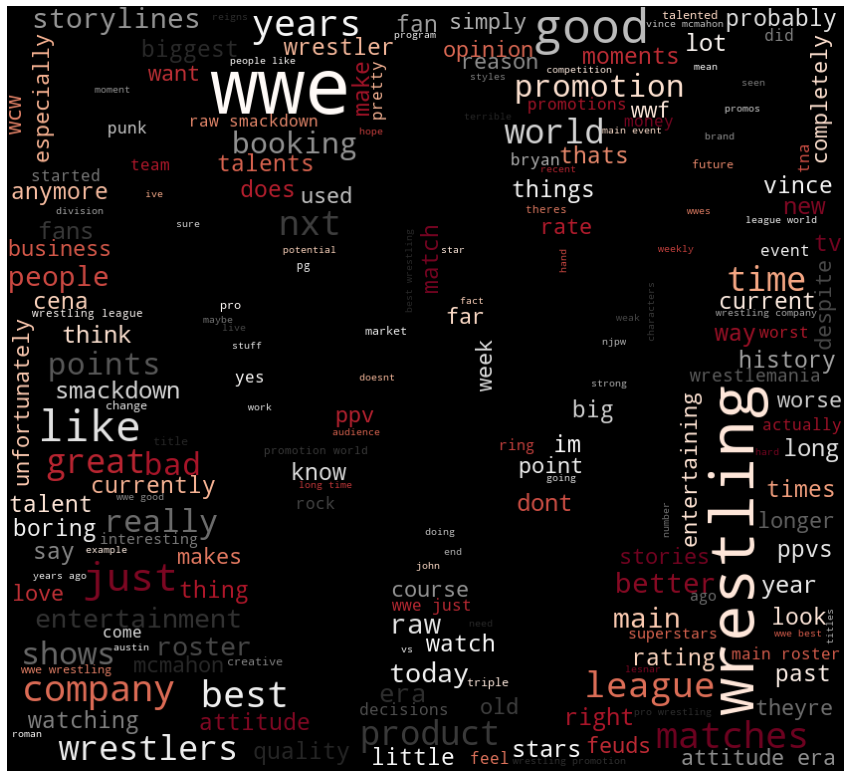

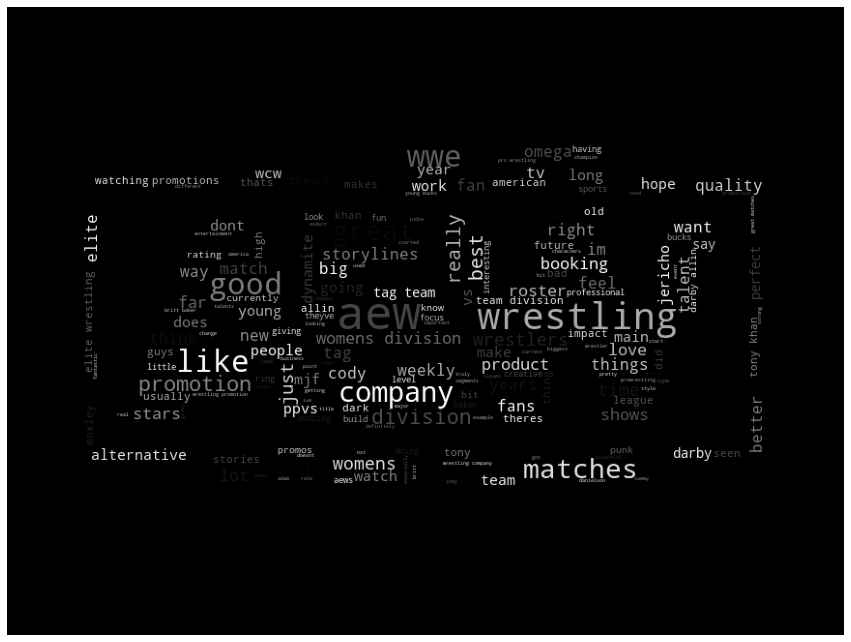

In [14]:
def plot_worcloud(imagefile, dtm_tposed, colormap):
    mask = np.array(Image.open(imagefile))
    wordcloud = WordCloud(width = 500, height = 500, random_state=1, background_color='black', colormap=colormap, collocations=False, mask=mask).generate_from_frequencies(dtm_tposed)

    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud) 
    plt.axis("off")

plot_worcloud('WWE_Logo.svg.png', wwe_dtm_tposed, 'RdGy')
plot_worcloud('aew_logo.jpeg', aew_dtm_tposed, 'Greys')


I also wanted to analyze the number of words that the reviewers tended to use in their reviews. That is why I created the 'total_words' column in the first big function. And it seems like AEW fans tend to be a bit more wordy in their delivery. Could it be that they're more passionate than WWE fans and consequently have more to say about the product? Who knows?

In [18]:
def central_tendency(promotion_df):
    print('Mean Number of Words: ', promotion_df['total_words'].mean())
    print('Median Number of Words: ', promotion_df['total_words'].median())
    print('Mode:')
    display(promotion_df['total_words'].value_counts().rename_axis('total_words').to_frame('count').head(1))

print(color.BOLD + color.RED + 'WWE Central Tendency' + color.END)
central_tendency(all_promotion_df.loc[all_promotion_df['promotion']== 'wwe'])
print()
print(color.BOLD + color.YELLOW + 'AEW Central Tendency' + color.END)
central_tendency(all_promotion_df.loc[all_promotion_df['promotion']== 'aew'])

WWE Central Tendency
Mean Number of Words:  89.45040650406504
Median Number of Words:  68.0
Mode:


,count
total_words,
35,11



AEW Central Tendency
Mean Number of Words:  117.20873786407768
Median Number of Words:  86.5
Mode:


,count
total_words,
20,5


*"Who knows?"*

Well, let's check. According to the ratings, it seems like AEW fans are much happier with the current product. However, we don't have much data to go by since the company has only been around for about 3 years, but they're definitely off to a good start. But man, look at how much WWE's ratings (in pink) have plummeted since 2007. People don't seem to be too happy with the product.

promotion,aaa,aew,impact,lu,njpw,roh,wwe
date,,,,,,,
2007,4.000000,NaN,5.307692,NaN,8.000000,9.384615,7.800000
2008,5.000000,NaN,5.615385,NaN,9.000000,8.512821,7.513889
2009,6.500000,NaN,6.566667,NaN,8.500000,8.200000,7.933333
2010,7.500000,NaN,5.163636,NaN,9.166667,8.590909,7.227273
2011,7.000000,NaN,4.172414,NaN,10.000000,9.000000,7.666667
2012,NaN,NaN,7.166667,NaN,9.600000,7.600000,6.684211
2013,8.000000,NaN,6.107143,NaN,9.875000,7.714286,7.400000
2014,NaN,NaN,5.277778,8.500000,9.700000,9.166667,8.043478
2015,8.666667,NaN,7.888889,8.607143,9.250000,9.000000,7.300000


<AxesSubplot:xlabel='date'>

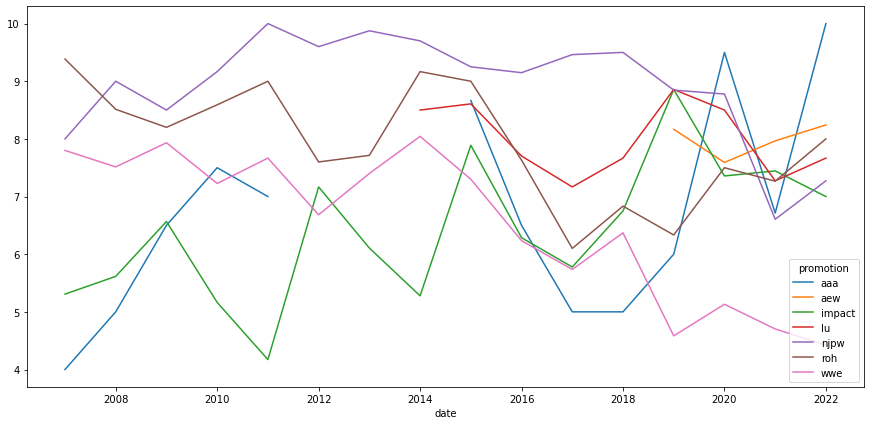

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
display(all_promotion_df.groupby([pd.to_datetime(all_promotion_df['date']).map(lambda x: x.year),'promotion']).mean()['rating'].unstack())
all_promotion_df.groupby([pd.to_datetime(all_promotion_df['date']).map(lambda x: x.year),'promotion']).mean()['rating'].unstack().plot(ax=ax)

I think that's a pretty good stopping point for EDA. Now, let's do some Topic Modeling. Like I mentioned earlier, I used Term Frequency for this and it was very useful, but I also wanted to see if TF-IDF would be useful as well. It's a more sophisticated way of quantifying the importance of the words in your data, so I had to give it a try.

Here's a simple description of TF-IDF:

- You already know TF. It's Term Frequency.

- IDF is a bit more complicated. It stands for Inverse Document Frequency, and it's basically how you quanitfy the number of documents that each word appears in. If a word appears in a bunch of documents (for example, 'the' is probably going to be in almost every document), it's probably not that important of a word. If every document has had a turn with a word, it's not going to score as high because it's been passed around so much. But a rare word that doesn't appear in many documents is going to have a high IDF score because it's seen as more important to understanding what your data is all about. You can't piece together what a collection of documents (aka "corpus") is talking about by looking at the words "the" or "a" or "it" over and over again. But you can get a good idea of what's going on if you see "raw", or "nxt", or "boring" (no correlation). So that's why we use IDF scores.

- And then, if you multiply TF and IDF together, you can get an even better idea of the importance of your words because you're mixing the frequency of the word with the document frequency of the word.

So that's what's basically going on below. I had to add some stop words because they were throwing off my topic models, I initially included unigrams *and* bigrams (bigrams are basically word pairs, ex. 'triple h' or 'cena sucks' instead of 'triple' or 'cena'), but that produced some less than optimal results, so I went back to unigrams. I created Term Frequency models/matrices and TF-IDF models/matrices because I wanted to test which method would work better.

In [378]:
more_wwe_stop_words = ['I', 'wwe', 'wrestling', 'good', 'really']
wwe_stop_words = text.ENGLISH_STOP_WORDS.union(more_wwe_stop_words)

more_aew_stop_words = ['I', 'aew']
aew_stop_words = text.ENGLISH_STOP_WORDS.union(more_aew_stop_words)

more_all_stop_words = ['I']
all_stop_words = text.ENGLISH_STOP_WORDS.union(more_all_stop_words)

def get_term_frequency(data, use_idf, stop_words, max_df=1.0, min_df=1, ngram_range=(1,1)):

    nlp = en_core_web_sm.load()

    def lem(text):
        lems = nlp(text)
        return [lemma.lemma_ for lemma in lems]

    if use_idf:
        model = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, ngram_range=ngram_range, tokenizer=lem)
    else:
        model = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, ngram_range=ngram_range, tokenizer=lem)
    
    sp_dtm = model.fit_transform(data)

    dtm = pd.DataFrame(sp_dtm.toarray(), columns = model.get_feature_names_out())

    return model, sp_dtm, dtm

wwe_tfidf_model, wwe_tfidf_sp_dtm, wwe_tfidf_dtm = get_term_frequency(all_promotion_df.loc[all_promotion_df['promotion']== 'wwe']['comment_clean'], use_idf=True, stop_words=wwe_stop_words, max_df=0.80, min_df=10)
wwe_tf_model, wwe_tf_sp_dtm, wwe_tf_dtm = get_term_frequency(all_promotion_df.loc[all_promotion_df['promotion']== 'wwe']['comment_clean'], use_idf=False, stop_words=wwe_stop_words, max_df=0.80, min_df=10)

aew_tfidf_model, aew_tfidf_sp_dtm, aew_tfidf_dtm = get_term_frequency(all_promotion_df.loc[all_promotion_df['promotion']== 'aew']['comment_clean'], use_idf=True, stop_words=aew_stop_words, max_df=0.90, min_df=10)
aew_tf_model, aew_tf_sp_dtm, aew_tf_dtm = get_term_frequency(all_promotion_df.loc[all_promotion_df['promotion']== 'aew']['comment_clean'], use_idf=False, stop_words=aew_stop_words, max_df=0.90, min_df=10)

Here is where I created the models. Like I said above, I used LDA and KMeans for topic modeling. LDA is typically how you would create a topic model, but I was interested in trying KMeans as well.

Also, without going too deep into everything, it's important to note that with LDA, a review can be a part of multiple topics. So let's say that I determine topic #1 to be about the Women's Division in WWE and topic #2 is about the Tag Team Division. Well, what happens when someone's review is a critique of the Women's Tag Team Division? Well, LDA might say that this document is 50% 'Women's Division' and 50% 'Tag Division' and that would be perfectly fine.

However, KMeans would not be able to do this. KMeans puts everything into clusters. Sure, you can find what words are popular in that cluster, but you can't say that that same Women's Division/Tag Team Division critique is 50% cluster #1 and 50% cluster #2. It's either associated with cluster #1 or with cluster #2. So KMeans offers a bit less flexibility.

In [381]:
class TopicModels:
    def __init__(self, data, topics):
        self.data = data
        self.topics = topics

    def get_lda(self):
        m = LatentDirichletAllocation(n_components= self.topics, n_jobs=-1, learning_method='online', random_state=1).fit(self.data)
        d = m.transform(self.data)
        return m, d

    def get_kmeans(self, scale=True):
        if scale:
            s = MinMaxScaler()
            data = s.fit_transform(self.data)
        
        m = KMeans(n_clusters = self.topics, random_state=1).fit(self.data)
        d = m.predict(self.data)
        return m, d 


        
def show_lda_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()


def show_kmeans_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()

In [382]:
n_topics = 5

t_modeler = TopicModels(wwe_tfidf_sp_dtm, n_topics)
lda_m, lda_d = t_modeler.get_lda()
kmean_m, kmean_d = t_modeler.get_kmeans(scale=False)

In [383]:
print("Top 10 stemmed words per topic in LDA model\n")
show_lda_topics(lda_m, wwe_tfidf_model.get_feature_names(), 10)

print()

print("Top 10 stemmed words per cluster in Kmeans model\n")
show_kmeans_topics(kmean_d, wwe_tfidf_sp_dtm, wwe_tfidf_model.get_feature_names(), 10)

Top 10 stemmed words per topic in LDA model

Topic #0:
life, thank, change, soon, hope, potential, today, bad, history, great
Topic #1:
league, just, match, year, like, time, bad, great, wrestler, company
Topic #2:
hart, bret, grow, hogan, rock, term, pretty, make, repetitive, talent
Topic #3:
fan, clear, wrestle, number, wwf, look, raw, thank, anymore, attitude
Topic #4:
world, leader, league, point, opinion, partly, entertainment, market, d, remain


Top 10 stemmed words per cluster in Kmeans model

Cluster #0:
league, world, just, big, opinion, make, like, wrestler, time, point
Cluster #1:
match, like, great, promotion, just, wrestler, bad, year, entertainment, watch
Cluster #2:
raw, nxt, smackdown, main, roster, year, point, ppvs, match, look
Cluster #3:
company, great, bad, wrestler, era, product, history, nxt, fan, wrestle
Cluster #4:
time, today, year, point, lot, just, long, product, storyline, wwf



I like the LDA topics for WWE, so here's what they mean to me: <br>

***Topic #0:***

life, thank, change, soon, hope, potential, today, bad, history, great

**Hoping that WWE goes back to how it used to be.**<br>
<br>

***Topic #1:***

league, just, match, year, like, time, bad, great, wrestler, company

**A bit unclear, but it seems like there is some discussion about the past and present versions of WWE.**<br>
<br>

***Topic #2:***

hart, bret, grow, hogan, rock, term, pretty, make, repetitive, talent

**Easy. Discussing the greats of the past and how today's wrestlers aren't the same.**<br>
<br>

***Topic #3:***

fan, clear, wrestle, number, wwf, look, raw, thank, anymore, attitude

**Reminiscing about the Attitude Era.**<br>
<br>

***Topic #4:***

world, leader, league, point, opinion, partly, entertainment, market, d, remain

**WWE's current position as a market leader and it's efforts to appeal to all fans.** 

And here's the topic modeling for AEW. I ended up using TF for this one, and I honestly like both the KMeans and LDA topics for this. LDA has topics that talk about specific superstars, comparisons to WCW, and certain nostlagic elements. KMeans has topics that compare the company to WWE and IMPACT, discuss ways for the company to improve, and offer praise. Both are pretty interesting.

In [384]:
k_topics = 6

t_modeler_aew = TopicModels(aew_tf_sp_dtm, k_topics)
lda_m, lda_d = t_modeler_aew.get_lda()
kmean_m, kmean_d = t_modeler_aew.get_kmeans(scale=False)

In [385]:
print("Top 10 stemmed words per topic in LDA model\n")
show_lda_topics(lda_m, aew_tf_model.get_feature_names(), 10)

print()

print("Top 10 stemmed words per cluster in Kmeans model\n")
show_kmeans_topics(kmean_d, aew_tfidf_sp_dtm, aew_tfidf_model.get_feature_names(), 10)

Top 10 stemmed words per topic in LDA model

Topic #0:
good, wcw, sure, company, promotion, far, look, america, lot, spot
Topic #1:
old, year, wwe, wrestling, new, company, feel, good, style, guy
Topic #2:
company, cody, rate, jericho, world, start,  , moxley, focus, champion
Topic #3:
good, division, wwe, like, make, match, wrestler, lot, just, thing
Topic #4:
wrestling, good, match, like, company, promotion, wwe, really, great, love
Topic #5:
good, wwe, great, like, star, match, company, think, promotion, talent


Top 10 stemmed words per cluster in Kmeans model

Cluster #0:
good, promotion, wrestling, match, great, love, wwe, like, year, really
Cluster #1:
promotion, d, wrestling, far, talent, impact, roster, fan, improve, build
Cluster #2:
good, division, star, match, great, wrestling, promotion, year, like, wrestler
Cluster #3:
wwe, company, wrestling, like, make, fan, just, s, really, match
Cluster #4:
usually, title, issue, match, make, big, promo, say, way, like
Cluster #5:
imp

Topic Modeling gave us some interesting results, but now let's build our prediction model. We'll start by creating a dataframe that removes all records that don't have a rating, and then we'll create document term matrices and train/test sets.

In [ ]:
all_promotion_df_no_na = all_promotion_df.dropna()
model_tfidf_m, model_tfidf_d, model_tfidf_dtm = get_term_frequency(all_promotion_df_no_na['comment_clean'], use_idf=True, stop_words='english', max_df=0.90, min_df=10)
X_train, X_test, y_train, y_test = train_test_split(model_tfidf_d, all_promotion_df_no_na['mark?'], test_size=0.3)

Now let's build some models. I saw that someone doing a similar project with Amazon Reviews used 4 different models for this, and I liked the idea. The four models are Logistic Regression, Support Vector Machines, Naive Bayes, and a Voting Classifier that uses the three aforementioned models in conjunction with each other to create a (hopefully) more robust model. By default is does 'hard' voting, which basically means that it votes based on the majority. So if the majority of models says that you're a 'Mark', the voting classifier will say you're a 'Mark' too.

In [131]:
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in all_promotion_df_no_na['mark?'].unique():
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

Model accuracy predictions

LR model (Not a Mark rating): 70.9%
LR model (Mark rating): 70.9%

SVM model (Not a Mark rating): 73.4%
SVM model (Mark rating): 73.4%

NB model (Not a Mark rating): 67.6%
NB model (Mark rating): 67.6%

COMBINED model (Not a Mark rating): 70.3%
COMBINED model (Mark rating): 70.3%



SVM was more accurate, but not by much, so let's go with the much simpler model that came in second place: Logistic Regression.

In [132]:
def get_lr(x, y):
    models = []
    for c in all_promotion_df_no_na['mark?'].unique():
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

Let's plot which words Marks use the most (and the least) and which words Non-Marks use the most (and the least).

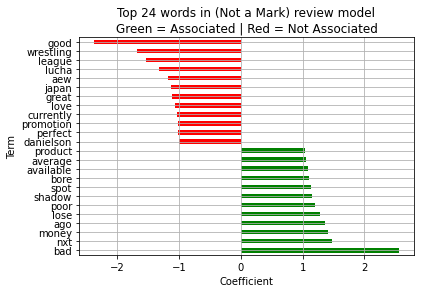

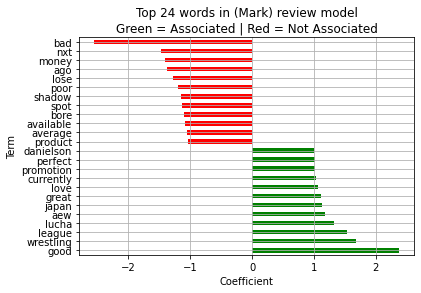

In [386]:
def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(all_promotion_df_no_na['mark?'].unique().tolist())):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=all_promotion_df_no_na['mark?'].unique().tolist()[c]), 
              lr_m[c], model_tfidf_m.get_feature_names(), n_terms)

I want to point out that Marks keep NXT's (the developmental program) name out of their mouths. However, they do tend to talk about other companies like AEW, Lucha, NJPW, etc.

But Non-Marks seem to love talking about NXT because at one point, NXT was the only good thing about WWE. So I could see why they would talk about that and maybe even compare the main product to that. There's no reason why the people who are supposed to be in development should be putting on a better show than the main guys that get paid more. That's like if G-League players started dunking on Lebron. It just wouldn't make much sense.

Anyway, let's make our model test-able and ready for a web application. The function below takes a test input and returns the results from the model.

In [231]:
def test_review(text):
    test_str = [text]
    test_new = model_tfidf_m.transform(test_str)

    line1 = 'Review text: "{R}"\n'.format(R=test_str[0])
    line2 = 'Model Predctions:'
    lines3_4 = []
    for m in range(0,2):
        lines3_4.append('{M} (Probability): {P:.1%}'.format(M=all_promotion_df_no_na['mark?'].unique().tolist()[m], P=lr_m[m].predict_proba(test_new)[0][1]))

    line_break = '-------------'

    for notmark, mark in zip(range(0,1), range(1,2)):
        if lr_m[notmark].predict_proba(test_new)[0][1] > lr_m[mark].predict_proba(test_new)[0][1]:
            line5 = 'Congratulations! You are not a Mark.'
        elif lr_m[notmark].predict_proba(test_new)[0][1] < lr_m[mark].predict_proba(test_new)[0][1]:
            line5 = 'You are definitely a Mark.'

    model_output = """{} \n {} \n {} \n {} \n {} \n \n""".format(line1, line2, line_break, lines3_4[0], lines3_4[1])

    return model_output, line5

Don't run this.

In [233]:
#cloudpickle.dump(test_review, open('test_review.pkl', 'wb'))

If you'd like to play around with some inputs and see how well the model can predict your review, please feel free to run the two code blocks below.

In [371]:
test_run = pickle.load(open('test_review.pkl', 'rb'))

In [388]:
user_review = input("How do you feel about WWE?:\n")

model_output, mark = test_run(user_review)

print(model_output, mark)

Review text: "Right now, I think WWE mostly sucks. I hope they get their act right one day, but for now, I am unimpressed. Wrestlemania was cool and nostalgic, but every other program feels stale. I want old school WWE back."
 
 Model Predctions: 
 ------------- 
 Not a Mark (Probability): 54.1% 
 Mark (Probability): 45.9% 
 
 Congratulations! You are not a Mark.


Thank you for viewing this notebook. My web application (app.py), virtual environment yaml file (wweVenv2.yaml), and all the accompanying files for this project are linked below:

https://github.com/FlamingoCalves/WrestlingReviews

Peace ✌🏾.